In [6]:
# Imports
'''
Program that performas a validation on the validation dataset. 
Several models, validation directories, ensembling methods, abstention thresholds are used.
Some parameters (especially those involving paths) are hard-coded because it's more convenient than putting them as command line argument, since they are always the same.

Arguments:
- thresholds
- ensMethods (if None, doesn't ensemble)

There is a memory problem when many models are loaded together.

The several metrics are given
- TP: True Positives
- FP: False Positives
- TN: True Negatives
- FN: False Negatives
- recall: TP/(TP+FN)
- precision: TP/(TP+FP)
- specificity: TN/(TN+FP)
- informedness: specificity + recall - 1
- accuracy: (TP+TN)/(TP+TN+FP+FN)

Runs as:
python validation.py -thresholds 0.0 0.9
'''


import os, keras, argparse, glob, pathlib, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from src import helper_data as hd, helper_models as hm
import train as t
import predict as pred



In [47]:

class Cval:

	def __init__(self, modelnames, testdirs, weightnames, labels, ensMethods, thresholds=0, training_data=False):

		self.InitClasses()

		self.thresholds = thresholds
		self.ensMethods = ensMethods

		self.ensembler=pred.Censemble(
									modelnames=modelnames, 
									weightnames=weightnames,
									testdirs=testdirs, 
									labels=labels,
									screen=False)
		# self.res     = self.Cvres()

		self.ensembler.MakePredictions()
		self.nimages=len(self.ensembler.im_names)

		return

	def InitClasses(self):
		                    
		self.__PLANKTONCLASSES__ = [\
		'asplanchna','asterionella','aphanizomenon','bosmina','ceratium','chaoborus',
		'conochilus','cyclops','daphnia','diaphanosoma',
		'dinobryon','eudiaptomus','fragilaria','hydra','kellikottia',
		'keratella_cochlearis','keratella_quadrata','leptodora','nauplius','paradileptus',
		'polyarthra','rotifers','synchaeta','trichocerca','uroglena']
		self.__JUNKCLASSES__=[\
		'copepod_skins','daphnia_skins','diatom_chain','dirt','filament','fish','maybe_cyano','unknown','unknown_plankton']
		self.__ALLCLASSES__ = self.__PLANKTONCLASSES__+self.__JUNKCLASSES__


	def PerClassValidation(self, ensembler):

		df_res = pd.DataFrame(index=ensembler.classnames, columns=['TP','FP','TN','FN','recall','precision','specificity','informedness','accuracy'])
		df_res.fillna(0) # Fill with zeros

		# Per class validation
		for myclass in ensembler.labels:

			# indices of the truths
			idLabels = list(filter(lambda i: ensembler.im_labels[i]==myclass, range(self.nimages) ))
			# how many of the truths were identified
			TP=(ensembler.guesses[idLabels,1]==ensembler.im_labels[idLabels]).astype(float).sum().astype(float)
			# how many of the truths were NOT identified
			FN=float(len(idLabels)-TP)

			# Indices of the guesses
			idGuesses = list(filter(lambda i: ensembler.guesses[i,1]==myclass, range(self.nimages) ))

			# Number of false positives
			FP=(ensembler.guesses[idGuesses,1]!=ensembler.im_labels[idGuesses]).astype(float).sum().astype(float)
			# Number of true negatives
			TN=float(len(ensembler.im_labels)-TP-FN-FP)

			df_res.loc[myclass]['TP'] = TP
			df_res.loc[myclass]['FN'] = FN
			df_res.loc[myclass]['FP'] = FP
			df_res.loc[myclass]['TN'] = TN

			df_res.loc[myclass]['recall'      ] = TP/(TP+FN) if TP+FN>0 else np.nan
			df_res.loc[myclass]['precision'   ] = TP/(TP+FP) if TP+FP>0 else np.nan
			df_res.loc[myclass]['specificity' ] = TN/(TN+FP) if FP+TN>0 else np.nan
			df_res.loc[myclass]['informedness'] = df_res.loc[myclass]['specificity' ]+df_res.loc[myclass]['recall' ]-1
			df_res.loc[myclass]['accuracy'    ] = (TP+TN)/(TP+TN+FP+FN)

		df_res.loc['mean_tot'  ] = df_res.mean()
		df_res.loc['mean_junk' ] = df_res.loc[self.__JUNKCLASSES__    ].mean()
		df_res.loc['mean_plank'] = df_res.loc[self.__PLANKTONCLASSES__].mean()
		
		df_res.loc['mean_tot'].accuracy = 1+df_res.loc[self.__ALLCLASSES__].TP/df_res.loc[self.__ALLCLASSES__].FP # TP/(TP+FP)

		return df_res

	def Sweep(self):
		for method in self.ensMethods:
			for absthres in self.thresholds:
				print('\nMethod:',method, '\tAbs-threshold:',absthres)
				self.ensembler.Ensemble(method=method, absthres=absthres)

				self.df_res=self.PerClassValidation(self.ensembler)
				print(self.df_res.loc['mean_plank'])
				self.Plot()

	def Plot(self):
		plt.figure(figsize=(30,30))
		ax1=plt.subplot(2,1,1)
		ax1.set_ylabel('Recall', fontsize=25)
		ax1.set_ylim((0,1))
		ax1.tick_params(axis='x', which='major', labelsize=20)
		plt.xticks(rotation=90)

		# Bar plot for all the plankton classes
		plt.bar(self.df_res.loc[self.__PLANKTONCLASSES__].index, self.df_res.loc[self.__PLANKTONCLASSES__].recall, width=.9, edgecolor='black', label='Per class')
		# Average recall over all plankton classes
		plt.plot(np.arange(len(self.__PLANKTONCLASSES__)), self.df_res.loc['mean_plank'].recall*np.ones(len(self.__PLANKTONCLASSES__)),'--', 
				linewidth=0.5,color='black', label='Average {}'.format(np.round(self.df_res.loc['mean_plank'].recall, decimals=2)))
		ax1.legend(loc='lower right')

		# Put extra labels on the plot with more info
		for i,c in enumerate(self.__PLANKTONCLASSES__):
			if np.isnan(self.df_res.loc[c]['TP']):
				label = 'NaN'
			else:
				hits  = int(self.df_res.loc[c]['TP'])
				total = int(self.df_res.loc[c][['TP','FN']].to_numpy().sum())
				label = str(hits)+'/'+str(total)
			plt.annotate(label , xy=(i-0.4, 0.5), fontsize=20)


		ax2=plt.subplot(2,1,2)
		ax2.set_ylabel('Precision', fontsize=25)
		ax2.set_ylim((0,1))
		ax2.tick_params(axis='x', which='major', labelsize=20)
		plt.xticks(rotation=90)

		# Bar plot for all the plankton classes
		plt.bar(self.df_res.loc[self.__PLANKTONCLASSES__].index, self.df_res.loc[self.__PLANKTONCLASSES__].precision, width=.9, edgecolor='black',label='Per class')
		# Average precision over all plankton classes
		plt.plot(np.arange(len(self.__PLANKTONCLASSES__)),self.df_res.loc['mean_plank'].precision*np.ones(len(self.__PLANKTONCLASSES__)),'--', linewidth=0.5,color='black', label='Average {}'.format(np.round(self.df_res.loc['mean_plank'].precision,decimals=2)))
		ax2.legend(loc='lower right')


		# Put extra labels on the plot with more info
		for i,c in enumerate(self.__PLANKTONCLASSES__):
			if np.isnan(self.df_res.loc[c]['TP']):
				label = 'NaN'
			else:
				hits  = int(self.df_res.loc[c]['TP'])
				total = int(self.df_res.loc[c][['TP','FP']].to_numpy().sum())
				label = str(hits)+'/'+str(total)
			plt.annotate(label , xy=(i-0.4, 0.5), fontsize=20)


		plt.show()

		return




In [48]:

if __name__=='__main__':

	#
	# Some hardcoded choices of testdirs:
	#

	# The Tommy validation dirs are obsolete and will be soon removed. They are only here for backward compatiblity tests.

	testdirs_tommy = [ \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/asplanchna', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/asterionella', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/bosmina', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/ceratium', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/chaoborus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/conochilus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/cyclops', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/daphnia', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/diaphanosoma', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/dinobryon', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/eudiaptomus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/fragilaria', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/kellikottia', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/keratella_cochlearis', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/keratella_quadrata', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/leptodora', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/nauplius', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/paradileptus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/rotifers', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/trichocerca', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/uroglena', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/dirt', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/filament', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/fish', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/maybe_cyano', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/unknown', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/tommy_validation/images/unknown_plankton', \
	] # do not put trailing '/' in the directory names


	testdirs_all = [ \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/asplanchna', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/asterionella', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/bosmina', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/ceratium', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/chaoborus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/conochilus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/cyclops', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/daphnia', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/diaphanosoma', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/dinobryon', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/dirt', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/eudiaptomus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/filament', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/fragilaria', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/kellikottia', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/keratella_cochlearis', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/keratella_quadrata', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/leptodora', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/maybe_cyano', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/nauplius', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/paradileptus', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/rotifers', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/trichocerca', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/unknown', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/unknown_plankton', \
				'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.04.28/uroglena', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/aphanizomenon', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/asplanchna', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/asterionella', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/bosmina', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/ceratium', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/chaoborus', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/conochilus', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/copepod_skins', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/cyclops', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/daphnia', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/daphnia_skins', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/diaphanosoma', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/diatom_chain', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/dinobryon', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/dirt', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/eudiaptomus', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/filament', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/fish', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/fragilaria', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/kellikottia', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/keratella_cochlearis', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/keratella_quadrata', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/leptodora', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/nauplius', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/paradileptus', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/polyarthra', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/rotifers', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/synchaeta', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/trichocerca', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/unknown', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/validation_2020.08.31/unknown_plankton', \
				#'/local/kyathasr/plankifier-master/data/1_zooplankton_0p5x/validation/.08.31/uroglena', \
	]



In [49]:
weightnames=['/local/kyathasr/plankifier-master/trained-models/mobilenet3/bestweights.hdf5']
modelnames=['/local/kyathasr/plankifier-master/trained-models/mobilenet3/keras_model.h5']
testdirs=testdirs_all
labels = [os.path.split(td)[1] for td in testdirs]



Method: leader 	Abs-threshold: 0.0
TP               6.71429
FP              0.809524
TN               228.857
FN              0.619048
recall          0.931061
precision       0.903813
specificity     0.996459
informedness     0.92752
accuracy        0.993972
Name: mean_plank, dtype: object


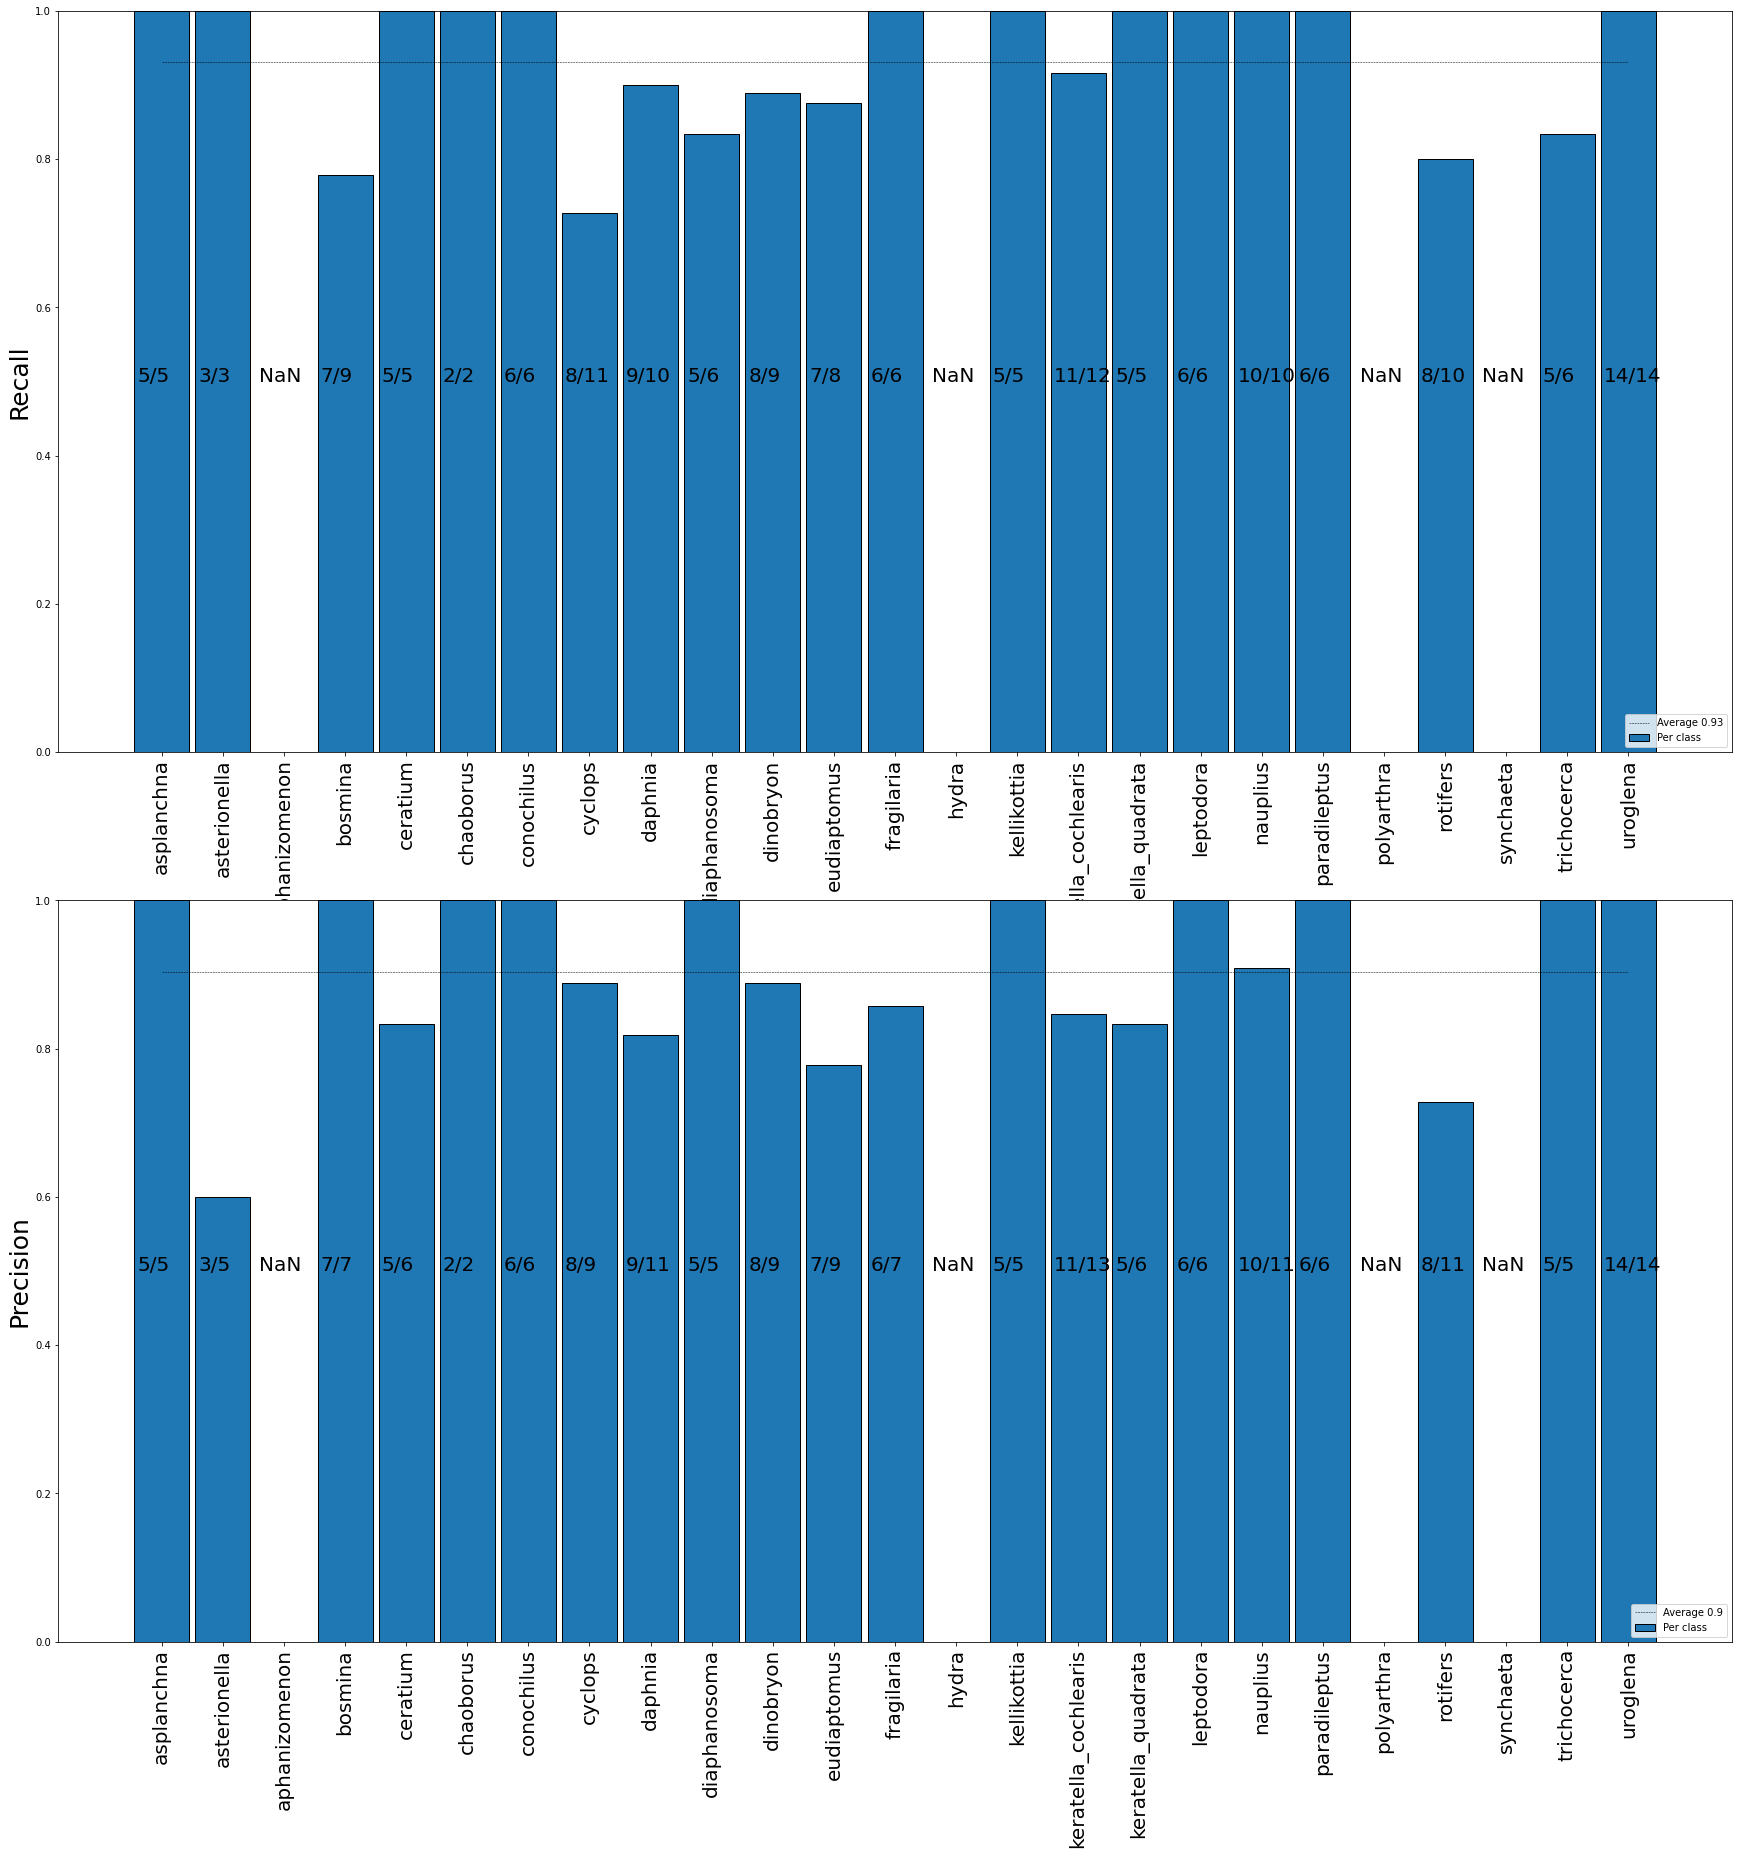

In [50]:
		validator = Cval(modelnames=modelnames, 
							testdirs=testdirs, 
							labels=labels,
							ensMethods=['leader'],
							thresholds=[0.0],
							weightnames=weightnames,
							training_data=True
							)
		validator.Sweep()